# PyTorch Autograd Engine: The Known, The Fun, and The Important

While there are plenty of guides on building models and using PyTorch's autograd engine, I found myself curious about the deeper mechanics: How does automatic differentiation actually work under the hood? Where and how are the derivatives of standard functions like `sigmoid`, `matmul`, or `softmax` implemented and stored? When I call `loss.backward()`, what exactly happens in the C++ backend?


# The known

Autograd (automatic differentiation) is PyTorch's automatic differentiation engine that powers neural network training. It automatically computes gradients of tensor operations, which are essential for backpropagation in deep learning.

### Core Concepts

#### 1. Computational Graph

PyTorch builds a dynamic computational graph (also called the autograd graph) as operations are performed. This graph consists of:

- Nodes: Represent tensors (data)
- Edges: Represent functions/operations that produced those tensors

Unlike static graph frameworks (old TensorFlow v1.x, Caffe...), PyTorch's graph is built on-the-fly during the forward pass and can change between iterations.

#### 2. Tensors with Gradient Tracking
When you create a tensor with `requires_grad=True`, PyTorch starts tracking all operations on it:

Each tensor has a `.grad_fn` attribute that references the function that created it
Leaf tensors (user-created) have `grad_fn=None` but can accumulate gradients in `.grad`

#### 3. The Gradient Tape Metaphor
Think of autograd as recording operations on a "tape" during the forward pass. During backward pass, it replays this tape in reverse to compute gradients using the chain rule.


### Key Components
#### 1. Tensor

* The fundamental data structure
* Contains data and metadata about gradient computation
* Has attributes like `requires_grad`, `grad`, `grad_fn`, `is_leaf`

#### 2. Function (grad_fn)

* Represents an operation in the graph
* Has `forward()` and `backward()` methods
* Stores references to input tensors and other context needed for gradient computation

#### 3. Engine

* Executes the backward pass
* Manages the traversal of the computational graph
* Handles gradient accumulation

In [1]:
import torch
import torch.nn as nn
from torchviz import make_dot

Using torchviz, we can easily visualize the Computational graph for smaller models. For more complex models, torchviz's diagram quickly become unreadable, in which case you may want to use [Netron](https://github.com/lutzroeder/netron) or [TensorBoard](https://www.tensorflow.org/tensorboard)


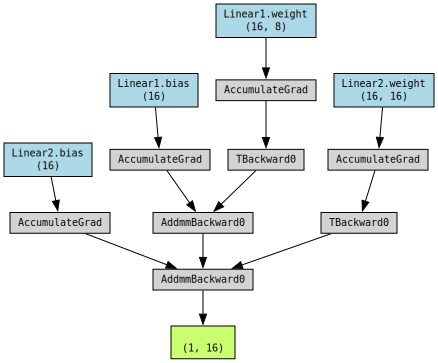

In [20]:
model = nn.Sequential()
model.add_module('Linear1', nn.Linear(8, 16))
model.add_module('Linear2', nn.Linear(16, 16))

x = torch.randn(1, 8)
y = model(x)
make_dot(y, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

This graph shows a simple two-layer network's computation graph. Notice the `AccumulateGrad` nodes that collect gradients for each parameter (weights and biases), and the `AddmmBackward0` nodes that represent the backward pass through linear layers (Add + matrix multiplication).

# The Fun

### ATen

**ATen** (A Tensor library) is PyTorch's low-level tensor computation backend - it's the foundation that everything else builds on top of. It provides performant C++ implementations of core tensor operations that PyTorch uses (you should recognize them all):

    // Basic arithmetic operations
    at::Tensor at::add(const Tensor& self, const Tensor& other, const Scalar& alpha);
    at::Tensor at::sub(const Tensor& self, const Tensor& other, const Scalar& alpha);
    at::Tensor at::mul(const Tensor& self, const Tensor& other);
    at::Tensor at::div(const Tensor& self, const Tensor& other);
    at::Tensor at::pow(const Tensor& self, const Scalar& exponent);

    // Matrix operations
    at::Tensor at::mm(const Tensor& self, const Tensor& mat2);
    at::Tensor at::bmm(const Tensor& self, const Tensor& mat2);
    at::Tensor at::matmul(const Tensor& self, const Tensor& other);

    // Reduction operations
    at::Tensor at::sum(const Tensor& self, IntArrayRef dim, bool keepdim);
    at::Tensor at::mean(const Tensor& self, IntArrayRef dim, bool keepdim);
    at::Tensor at::max(const Tensor& self, int64_t dim, bool keepdim);

    // Activation functions
    at::Tensor at::relu(const Tensor& self);
    at::Tensor at::sigmoid(const Tensor& self);
    at::Tensor at::tanh(const Tensor& self);
    at::Tensor at::softmax(const Tensor& self, int64_t dim, ScalarType dtype);

All these functions are defined in `native_functions.yaml`, which can specify different C++ implementations for different platforms (CPU, CUDA, MPS, ...), which enables PyTorch's polymorphic dispatch of the function depending on the platform:

    - func: add.Tensor(Tensor self, Tensor other, *, Scalar alpha=1) -> Tensor
      device_check: NoCheck
      device_guard: False
      dispatch:
        CPU: add_cpu
        CUDA: add_cuda
        MPS: add_mps
      tags: pointwise




### Where Do Derivatives Live?

Still, these are implementations of the functions themselves, and that lib does not provide derivatives of all those functions. Those are defined in `derivatives.yaml` file.
For simpler entries (one-liners), derivatives are defined within the yaml file itself:

    - name: bmm(Tensor self, Tensor mat2) -> Tensor
      self: grad.bmm(mat2.transpose(1, 2).conj())
      mat2: self.transpose(1, 2).conj().bmm(grad)
      result: self_t.bmm(mat2_p) + self_p.bmm(mat2_t)

This is example of batch matrix multiplication.
* Inputs are two 3D tensors `self` (shape: B×N×K) and `mat2` (shape: B×K×M)
* And that gives us as output a single 3D tensor (shape: B×N×M)

#### Derivation with respect to "self":

* If output = self @ mat2, then $\frac{\partial \text{output}}{\partial \text{self}} = \text{mat2}^T$
* Using chain rule: grad_self = grad_output @ $mat2^T$
* In batch form: **grad.bmm(mat2.transpose(1, 2).conj())**

#### Derivation with respect to "mat2":
* If output = self @ mat2, then $\frac{\partial output}{\partial mat2} = self^T$
* Using chain rule: grad_mat2 = $self^T$ @ grad_output
* In batch form: **self.transpose(1, 2).conj().bmm(grad)**

In case when more complex implementation is needed, then the implementation of derivative function is implemented in C++ in file `FunctionsManual.cpp` (torch/csrc/autograd/FunctionsManual.cpp) and is referenced in `derivatives.yaml` (as pow_backward() is). Here is the example input for pow() function (three pow() flavors: Tensor^Scalar, Tensor^Tensor, Scalar^Tensor):

    - name: pow.Tensor_Scalar(Tensor self, Scalar exponent) -> Tensor
      self: pow_backward(grad, self, exponent)
      result: auto_element_wise

    - name: pow.Tensor_Tensor(Tensor self, Tensor exponent) -> Tensor
      self: pow_backward_self(grad, self, exponent)
      exponent: pow_backward_exponent(grad, self, exponent, result)
      result: (pow_backward_self(self_t.conj(), self_p, exponent_p) + pow_backward_exponent(exponent_t.conj(), self_p, exponent_p, result)).conj()

    - name: pow.Scalar(Scalar self, Tensor exponent) -> Tensor
      exponent: pow_backward_exponent(grad, self, exponent, result)
      result: auto_element_wise

So: one-liner derivatives are defined directly in the entry in `derivatives.yaml` file, while derivatives requiring more logic/branching are implemented in `FunctionsManual.cpp` and then referenced in `derivatives.yaml`.


### C++ code generation

The `gen_autograd.py` script processes `native_functions.yaml` along with `derivatives.yaml` to generate the following:

C++ Function Declarations - Headers for all ATen functions
Dispatcher Registration - Maps function names to implementations
Python Bindings - Makes functions callable from Python
Type Checking - Validates tensor types and shapes
Autograd Integration - Connects with gradient computation system


To run it yourself, this is the line, with no external dependencies needed:

    python tools/autograd/gen_autograd.py aten/src/ATen/native/native_functions.yaml aten/src/ATen/native/tags.yaml build/generated tools/autograd


You should end up with following generated files:

    * Functions.h/Functions.cpp    # ATen function declarations
    * NativeFunctions.h            # Function registry
    * VariableType.cpp             # Autograd wrappers
    * python_torch_functions.cpp   # Python bindings
    * Operators.cpp                # Dispatcher registration

# The Important

If you want/need to implement new custom function you have multiple options available.
Let's pretend that new revolutionary function you see for the first time is Swish activation function `swish = x * sigmoid(x)`.

For a function as simple as this, PyTorch will handle the differentiation automatically easily, thus only forward step implementation is needed.

Gradient: tensor([0.9277, 1.0908, 0.0723])


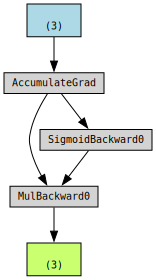

In [33]:
def swish(x):
    return x * torch.sigmoid(x)

x = torch.tensor([1.0, 2.0, -1.0], requires_grad=True)
y = swish(x)
y.sum().backward()

print(f"Gradient: {x.grad}")

make_dot(y)

Here you can see how PyTorch automatically constructs the graph for our swish function. The `SigmoidBackward0` and `MulBackward0` nodes show that PyTorch decomposed our operation into its components and will handle the chain rule automatically during backpropagation.

When you need more control or specific optimisation, you would implement backward method of the function manually.

$$\begin{align}
\frac{d}{dx}[x \cdot \sigma(x)] &= \frac{d}{dx}[x] \cdot \sigma(x) + x \cdot \frac{d}{dx}[\sigma(x)] \\
&= \sigma(x) + x \cdot \sigma(x) \cdot (1 - \sigma(x)) \\
&= \sigma(x) \cdot (1 + x \cdot (1 - \sigma(x)))
\end{align}$$


Gradient: tensor([0.9277, 1.0908, 0.0723])


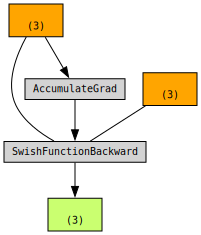

In [31]:
class SwishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Compute swish: x * sigmoid(x)
        sigmoid = torch.sigmoid(input)
        output = input * sigmoid

        # Save tensors needed for backward
        ctx.save_for_backward(input, sigmoid)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve saved tensors
        input, sigmoid = ctx.saved_tensors

        # Derivative of swish:
        # d/dx(x * sigmoid(x)) = sigmoid(x) + x * sigmoid(x) * (1 - sigmoid(x))
        #                      = sigmoid(x) * (1 + x * (1 - sigmoid(x)))

        grad_input = grad_output * (sigmoid * (1 + input * (1 - sigmoid)))

        return grad_input

# Create a convenient wrapper
class Swish(nn.Module):
    def forward(self, x):
        return SwishFunction.apply(x)

# Test it
x = torch.tensor([1.0, 2.0, -1.0], requires_grad=True)
swish = Swish()
y = swish(x)
y.sum().backward(retain_graph=True)

print(f"Gradient: {x.grad}")
make_dot(y, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

With our custom autograd function, the entire operation appears as a single `SwishFunctionBackward` node.
This encapsulates both the forward and backward logic we defined, giving us complete control over how gradients are computed.

For performance reasons, you may want to implement a function in C++ with a python binding around it.

    #include <torch/extension.h>
    #include <vector>

     // Forward declaration
     std::vector<torch::Tensor> swish_forward(torch::Tensor input);
     std::vector<torch::Tensor> swish_backward(torch::Tensor grad_output,
                                               torch::Tensor input,
                                               torch::Tensor sigmoid);

     // Implementations
     std::vector<torch::Tensor> swish_forward(torch::Tensor input) {
         auto sigmoid = torch::sigmoid(input);
         auto output = input * sigmoid;
         return {output, sigmoid};  // Return sigmoid for backward
     }

     std::vector<torch::Tensor> swish_backward(torch::Tensor grad_output,
                                               torch::Tensor input,
                                               torch::Tensor sigmoid) {
         // swish'(x) = sigmoid(x) * (1 + x * (1 - sigmoid(x)))
         auto grad_input = grad_output * sigmoid * (1 + input * (1 - sigmoid));
         return {grad_input};
     }

     // Python bindings
     PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
         m.def("forward", &swish_forward, "Swish forward");
         m.def("backward", &swish_backward, "Swish backward");
     }

... and python bindings:

    from torch.utils.cpp_extension import load_inline

    swish_cpp = load_inline(
        name='swish_cpp',
        cpp_sources=[open('swish.cpp').read()],
        functions=['forward', 'backward']
    )

    class SwishCpp(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input):
            output, sigmoid = swish_cpp.forward(input)
            ctx.save_for_backward(input, sigmoid)
            return output

        @staticmethod
        def backward(ctx, grad_output):
            input, sigmoid = ctx.saved_tensors
            grad_input = swish_cpp.backward(grad_output, input, sigmoid)[0]
            return grad_input

Further, you may want to implement multiple implementations for different backends to use PyTorch's builtin dispatcher:

    import torch
    from torch.library import Library, impl

    myops = Library("myops", "DEF")
    myops.define("swish(Tensor self) -> Tensor")

    @impl(myops, "swish", "CPU")
    def swish_cpu(x):
        return x * torch.sigmoid(x)

    @impl(myops, "swish", "CUDA")
    def swish_cuda(x):
        return x * torch.sigmoid(x)

    @impl(myops, "swish", "Autograd")
    def swish_autograd(x):
        # Use custom autograd function
        return SwishFunction.apply(x)

    class SwishFunction(torch.autograd.Function):
        @staticmethod
        def forward(ctx, x):
            sigmoid = torch.sigmoid(x)
            ctx.save_for_backward(x, sigmoid)
            return x * sigmoid

        @staticmethod
        def backward(ctx, grad_output):
            x, sigmoid = ctx.saved_tensors
            return grad_output * (sigmoid * (1 + x * (1 - sigmoid)))

After you register it, you can access the operator directly under the Torch.ops namespace.:

    x = torch.randn(5, requires_grad=True)
    y = torch.ops.myops.swish(x)
    y.sum().backward()
    print(x.grad)

### Having issue with gradients?

Ever had your model mysteriously produce NaN gradients and spent hours staring at tensors trying to figure out where things went wrong?
The `detect_anomaly()` context manager helps debug NaN/Inf gradients by adding runtime checks during backpropagation. When enabled, PyTorch validates each gradient computation and immediately raises an exception with a detailed traceback when it encounters invalid values, pinpointing the exact operation that failed. While this slows down training considerably, it transforms opaque NaN errors into actionable debugging information, making it invaluable for diagnosing gradient instability issues during development.

    with torch.autograd.detect_anomaly():
        y = model(x)
        loss = criterion(y, target)
        loss.backward()  # Will provide detailed error info if NaN/Inf

### Gradient checkpointing

If working on a local machine, gradient checkpointing can be very useful as it's a memory-saving technique that trades computation time for memory usage. Here's how it works:

#### Normal Forward Pass (without checkpointing)

    x = self.layer1(x)  # Computes output AND stores all intermediate activations
    x = self.layer2(x)  # Uses layer1's output, stores its own activations too
    loss = criterion(x)
    loss.backward()     # Uses stored activations to compute gradients

During normal forward pass, PyTorch stores all intermediate tensors needed for the backward pass. For `layer1`, this includes:

* Input activations
* Weight matrices
* Any intermediate computations (like pre-activation values)
For a large model, this can consume massive amounts of memory.

#### With Checkpointing
    x = checkpoint(self.layer1, x)  # Computes output but DISCARDS intermediate activations
    x = self.layer2(x)               # Normal forward pass
    loss = criterion(x)
    loss.backward()                  # Re-computes layer1 forward pass when needed

Here's what happens in this case:

1) Forward pass: `checkpoint(self.layer1, x)` runs layer1 forward but only keeps the final output, **discarding intermediate activations to save memory**.
2) Backward pass: When gradients reach `layer1`, PyTorch:
    * Re-runs the forward pass of `layer1` to recreate the intermediate activations
    * Then computes gradients normally using these recreated activations
    * This **doubles the computation time** for `layer1` but saves memory


## Conclusion

Understanding PyTorch's autograd internals lets you:

* Debug gradient flow issues when your model won't train
* Implement custom operations that autograd can't handle automatically
* Optimize memory and computation for large-scale training
* Extend PyTorch with domain-specific functions that are actually fast

The key takeaways:

1) **The Known**: PyTorch builds dynamic graphs that can change every iteration
2) **The Fun**: Derivatives live in YAML files and get compiled to C++
3) **The Important**: You can extend autograd at multiple levels, from pure Python to CUDA kernels

Whether you're debugging why your gradients exploded or implementing that paper's weird activation function, knowing how autograd works under the hood turns mysterious errors into solvable problems.